In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
import pickle

In [14]:
df = pd.read_csv('Dataset/Dataset.csv')
df

,RMS,MAV,WL,ZC,MDF,MNF,MNP,SSC,IMDF,IMPF,PSD,stft_feature_1,stft_feature_2,stft_feature_3,stft_feature_4,stft_feature_5,stft_feature_6,Label
0,0.024953,0.024870,0.037430,0,0.000,10.805463,0.000027,15,31.747112,32.006192,2.186874e-09,74.769205,12.911638,65.180109,160.605635,26.596594,126.847386,0
1,0.023091,0.022963,0.037095,0,0.000,10.204153,0.000023,12,32.337447,32.593577,4.407695e-09,60.358633,13.280772,67.433455,121.663454,27.761574,127.787611,0
2,0.021128,0.021018,0.033066,0,0.000,10.725278,0.000019,16,32.639442,32.886445,5.671775e-09,66.095382,13.064910,63.569236,132.194533,30.432690,124.216214,0
3,0.022775,0.022524,0.033234,0,0.000,9.712029,0.000022,17,32.289559,32.725720,7.148809e-09,56.831005,12.252091,63.229654,128.018110,28.768842,125.226733,0
4,0.023908,0.023746,0.033906,0,0.000,8.388730,0.000025,15,31.660105,31.810773,3.709064e-09,47.905922,12.687956,69.824501,103.377111,26.126006,142.998050,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113388,0.092962,0.072436,0.508919,1,31.250,49.264022,0.000240,3,45.442088,46.495901,2.056883e-06,58.366300,88.580010,112.839383,85.838451,67.420892,170.149886,3
113389,0.160437,0.132494,0.923507,2,31.250,35.256724,0.000722,2,56.570583,55.838411,2.473600e-05,165.200418,45.735178,80.020819,183.769213,47.504485,105.310403,3
113390,0.144792,0.113522,0.914107,2,31.250,46.588322,0.000583,4,69.176655,68.129713,2.030254e-05,123.093309,58.882269,119.559524,138.698344,51.118122,190.470098,3
113391,0.091929,0.080069,0.515465,1,15.625,21.239311,0.000302,5,38.737469,38.670645,1.366064e-06,282.850358,19.804241,46.684069,231.137675,39.411512,59.419190,3


In [15]:
# Analyze label distribution
label_counts = df['Label'].value_counts()
print("Label Distribution:\n", label_counts)

Label Distribution:
 Label
1    32284
2    28748
3    28525
0    23836
Name: count, dtype: int64


<ipython-input-16-474385466569>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




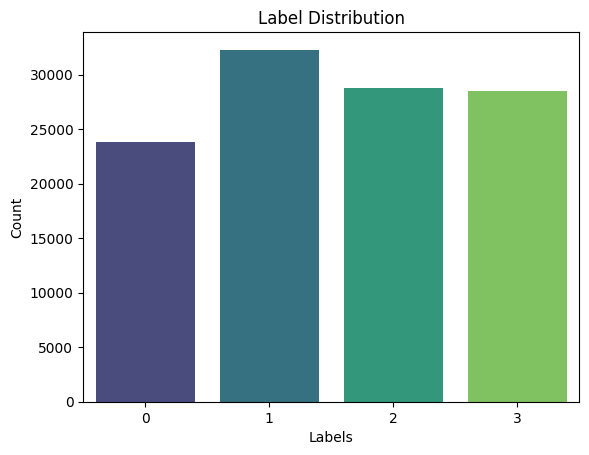

In [16]:
# Plot label distribution with seaborn
sns.countplot(x='Label', data=df, palette='viridis')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()


In [19]:
feature_columns = ['RMS', 'MAV', 'WL', 'SSC', 'MDF', 'MNF', 'MNP', 'PSD', 'stft_feature_1', 'stft_feature_2', 'stft_feature_3']
Label_column = ['Label']

In [20]:
# Split the DataFrame into features (X) and target (y)
X = df[feature_columns]
Y = df[Label_column]  # Replace 'target_column' with the name of your target column


In [21]:
X.shape

(113393, 11)

In [22]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
timesteps = 300
num_features = X_scaled.shape[1]

data_segments = {f'X{j}': [] for j in range(num_features)}  # Dictionary to store segments for each feature
y = []  # List to store labels

# Segment the data from df
for i in range(0, X.shape[0] - timesteps):
    for j in range(num_features):  # Loop for column indexing
        data_segments[f'X{j}'].append(X.iloc[i:i + timesteps, j].values)

# Segment the labels from labels_df
for i in range(0, Y.shape[0] - timesteps):
    y.append(Y.iloc[i + timesteps, 0])  # Assuming the label to predict is the last one in the window


In [24]:
y_encoded= to_categorical(y, num_classes=4)

In [25]:
# Convert lists in data_segments to NumPy arrays for easier manipulation
X_segments = np.array([np.array(data_segments[f'X{j}']) for j in range(num_features)])
X_segments = np.swapaxes(X_segments, 0, 1)  # Swap axes to get the shape (samples, timesteps, features)
X_segments = np.swapaxes(X_segments, 1, 2)  # Final shape: (samples, timesteps, features)

# Convert labels list to a NumPy array
Y = np.array(y_encoded)

# Splitting the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_segments, Y, test_size=0.2, random_state=2)


In [27]:
# Assuming X_train.shape = (num_samples, sequence_length, features)
num_features = X_train.shape[2]  # Number of features in the input
sequence_length = X_train.shape[1]  # Sequence length
num_classes = 4  # Number of output classes

# Define the inputs
inputs = Input(shape=(sequence_length, num_features))

# Transformer block
# For self-attention in transformers, query, key, and value are typically the same (the input)
attention_output = MultiHeadAttention(key_dim=num_features, num_heads=3)(inputs, inputs)
attention_output = Dropout(0.1)(attention_output)
attention_output = LayerNormalization(epsilon=1e-5)(attention_output + inputs)  # Add & Norm

# Pooling layer to reduce sequence dimension
pooled_output = GlobalAveragePooling1D()(attention_output)

# Fully connected layers
x = Dense(64, activation='relu')(pooled_output)
#x = Dense(128, activation='relu')(x)
#x = Dense(64, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer for multi-class classification

# Create the model
model_transformer = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model_transformer.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model_transformer.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 11)]            0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 300, 11)              1562      ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 300, 11)              0         ['multi_head_attention[0][0]']
                                                                                                  
 tf.__operators__.add (TFOp  (None, 300, 11)              0         ['dropout[0][0]',         

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# Learning rate reduction to reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [29]:
history = model_transformer.fit(X_train, Y_train, epochs=200, batch_size=32, validation_split=0.1,callbacks=[early_stopping])

Epoch 1/200
2545/2545 [==============================] - 29s 9ms/step - loss: 0.8783 - accuracy: 0.6069 - val_loss: 0.6862 - val_accuracy: 0.6956
Epoch 2/200
2545/2545 [==============================] - 22s 9ms/step - loss: 0.6184 - accuracy: 0.7257 - val_loss: 0.5791 - val_accuracy: 0.7386
Epoch 3/200
2545/2545 [==============================] - 22s 9ms/step - loss: 0.5400 - accuracy: 0.7621 - val_loss: 0.5138 - val_accuracy: 0.7733
Epoch 4/200
2545/2545 [==============================] - 21s 8ms/step - loss: 0.4919 - accuracy: 0.7842 - val_loss: 0.4874 - val_accuracy: 0.7782
Epoch 5/200
2545/2545 [==============================] - 22s 9ms/step - loss: 0.4593 - accuracy: 0.7994 - val_loss: 0.4438 - val_accuracy: 0.8038
Epoch 6/200
2545/2545 [==============================] - 22s 9ms/step - loss: 0.4329 - accuracy: 0.8118 - val_loss: 0.4409 - val_accuracy: 0.8008
Epoch 7/200
2545/2545 [==============================] - 21s 8ms/step - loss: 0.4160 - accuracy: 0.8205 - val_loss: 0.4220 -

In [30]:
# Evaluate the model on the test set
y_pred = model_transformer.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax output to class labels


707/707 [==============================] - 3s 4ms/step


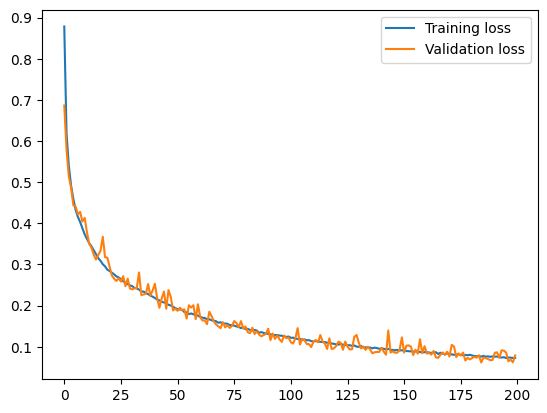

In [31]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [32]:
# Calculate test accuracy
test_accuracy = accuracy_score(np.argmax(Y_test, axis=1), y_pred_classes)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.973738892081878


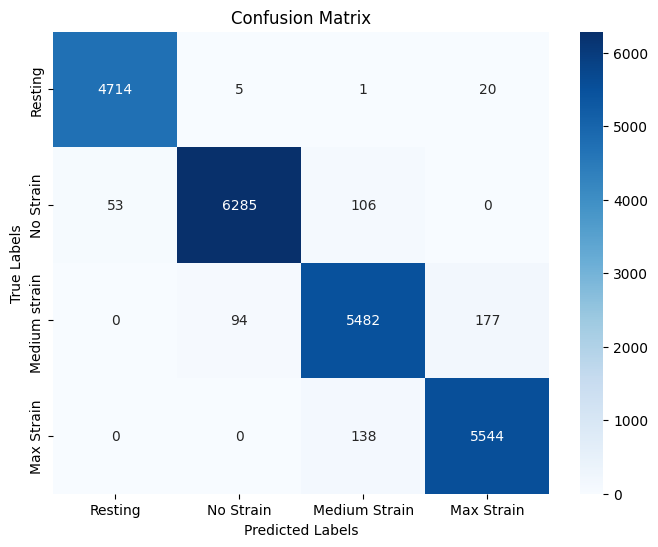

In [33]:
# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(Y_test, axis=1), y_pred_classes)

# Plot confusion matrix as heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Resting', 'No Strain','Medium Strain','Max Strain'], yticklabels=['Resting', 'No Strain','Medium strain ','Max Strain'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [34]:
start_time = time.time()

X_train_pred = model_transformer.predict(X_test)
# End the timer
end_time = time.time()

# Calculate the inference time
inference_time = end_time - start_time
print("Inference time:", inference_time)

707/707 [==============================] - 2s 3ms/step
Inference time: 3.5601680278778076


In [ ]:
model_transformer.save('Transformer.keras')

In [37]:
# Save the scaler to a file
with open('scalerT.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("Scaler has been saved as 'scalerT.pkl'")

Scaler has been saved as 'scalerT.pkl'
